In [1]:
import os
import zipfile
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks


In [2]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Lung_Cancer.zip'
extract_path = '/content/Lung_Cancer'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')


Mounted at /content/drive


In [6]:
import os

base_path = "/content/Lung_Cancer"
classes = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]  # Filter for directories
print("Classes found:", classes)

for cls in classes:
    cls_path = os.path.join(base_path, cls)
    print(f"{cls} has {len(os.listdir(cls_path))} images")

Classes found: ['Lung_Squamous_Cell_Carcinoma', 'Lung-Benign_Tissue', 'Lung_Adenocarcinoma']
Lung_Squamous_Cell_Carcinoma has 4724 images
Lung-Benign_Tissue has 4744 images
Lung_Adenocarcinoma has 4727 images


In [5]:
import hashlib
import os

def remove_duplicates(base_dir):
    print("Scanning for duplicate images...")
    hashes = set()
    removed = 0
    for class_dir in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_dir)
        # Check if class_path is a directory before proceeding
        if os.path.isdir(class_path): # Add this condition to ensure only directories are processed
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with open(img_path, 'rb') as f:
                        img_hash = hashlib.md5(f.read()).hexdigest()
                    if img_hash in hashes:
                        os.remove(img_path)
                        removed += 1
                    else:
                        hashes.add(img_hash)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    print(f"Removed {removed} duplicate images.")

# Call the function
remove_duplicates(extract_path)

Scanning for duplicate images...
Removed 0 duplicate images.


In [8]:
def prepare_data_splits(base_dir, output_dir='/content/Lung_Cancer_Split'):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    os.makedirs(output_dir, exist_ok=True)
    for split in ['train', 'val', 'test']:
        for cls in os.listdir(base_dir):
            # Check if the entry is a directory before creating a path for it
            if os.path.isdir(os.path.join(base_dir, cls)):
                os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        # Check if the entry is a directory before proceeding
        if os.path.isdir(cls_path):
            images = os.listdir(cls_path)
            random.shuffle(images)

            train_split = int(0.7 * len(images))
            val_split = int(0.85 * len(images))

            for i, img_name in enumerate(images):
                src_path = os.path.join(cls_path, img_name)
                if i < train_split:
                    dst_path = os.path.join(output_dir, 'train', cls, img_name)
                elif i < val_split:
                    dst_path = os.path.join(output_dir, 'val', cls, img_name)
                else:
                    dst_path = os.path.join(output_dir, 'test', cls, img_name)
                shutil.copy(src_path, dst_path)

    return output_dir

In [10]:
# Call the prepare_data_splits function to create the split dataset and get the path
split_path = prepare_data_splits(extract_path)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, rotation_range=10)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

target_size = (224, 224)
batch_size = 32

# Now 'split_path' is defined and can be used in the following lines
train_generator = train_datagen.flow_from_directory(
    os.path.join(split_path, 'train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(split_path, 'val'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(split_path, 'test'),
    target_size=target_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 9934 images belonging to 3 classes.
Found 2130 images belonging to 3 classes.
Found 2131 images belonging to 3 classes.


In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop]
)


Epoch 1/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 187s 572ms/step - accuracy: 0.8414 - loss: 0.3722 - val_accuracy: 0.9587 - val_loss: 0.1123
Epoch 2/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 175s 493ms/step - accuracy: 0.9607 - loss: 0.0972 - val_accuracy: 0.9643 - val_loss: 0.0927
Epoch 3/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 152s 490ms/step - accuracy: 0.9721 - loss: 0.0758 - val_accuracy: 0.9732 - val_loss: 0.0707
Epoch 4/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 202s 488ms/step - accuracy: 0.9774 - loss: 0.0613 - val_accuracy: 0.9671 - val_loss: 0.0736
Epoch 5/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 156s 500ms/step - accuracy: 0.9841 - loss: 0.0513 - val_accuracy: 0.9742 - val_loss: 0.0571


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.9893 - loss: 0.0253
Test Accuracy: 0.98
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step


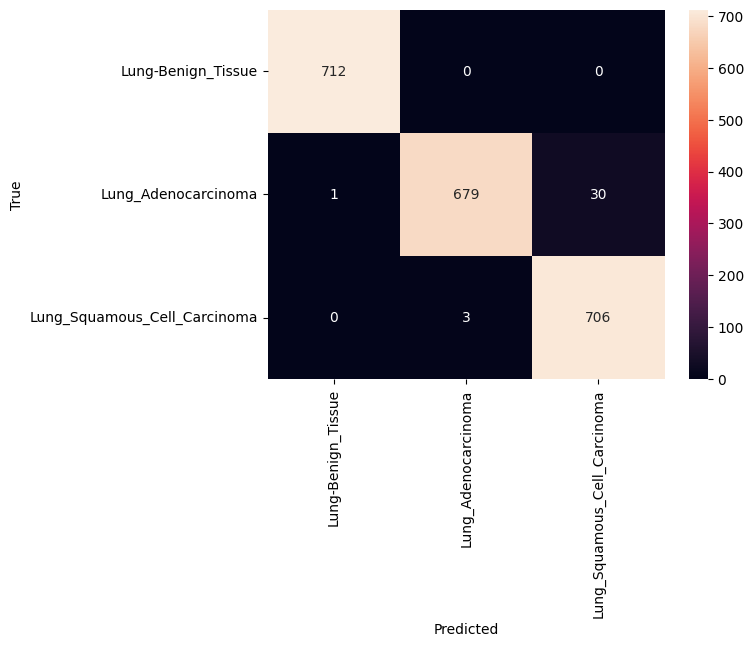

                              precision    recall  f1-score   support

          Lung-Benign_Tissue       1.00      1.00      1.00       712
         Lung_Adenocarcinoma       1.00      0.96      0.98       710
Lung_Squamous_Cell_Carcinoma       0.96      1.00      0.98       709

                    accuracy                           0.98      2131
                   macro avg       0.98      0.98      0.98      2131
                weighted avg       0.98      0.98      0.98      2131



In [13]:
# Test evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=train_generator.class_indices.keys()))


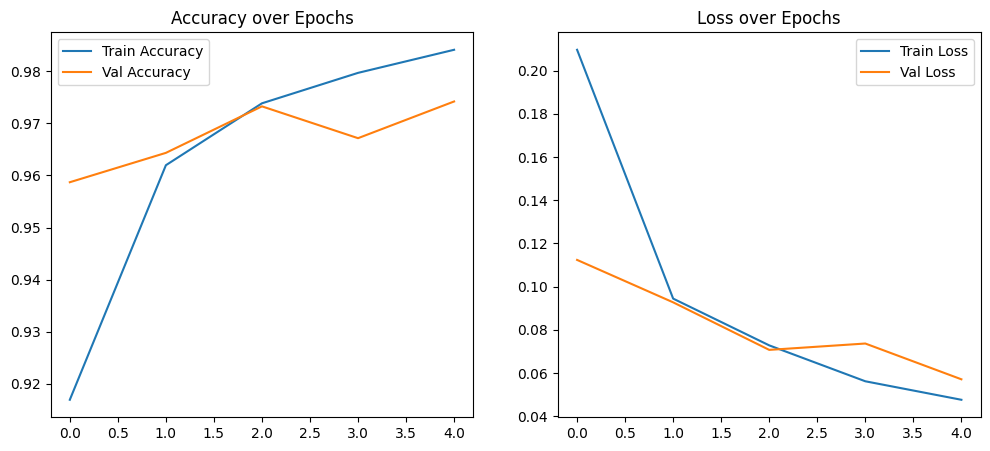

In [14]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

# Call this after model.fit()
plot_training_history(history)


In [15]:
# Test evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Validation Accuracy (from training history)
val_acc = history.history['val_accuracy']
print(f"Validation Accuracy: {val_acc[-1]:.2f}") # Get the last value

# Train Accuracy (from training history)
train_acc = history.history['accuracy']
print(f"Train Accuracy: {train_acc[-1]:.2f}")  # Get the last value


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.9893 - loss: 0.0253
Test Accuracy: 0.98
Validation Accuracy: 0.97
Train Accuracy: 0.98


In [16]:
model.save('/content/lung_cancer_model.h5')


In [17]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/lung_cancer_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: Lung-Benign_Tissue


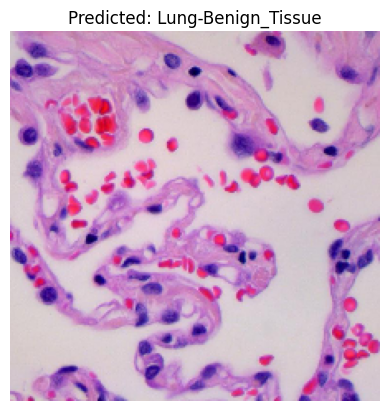

In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

def predict_image_class(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    predicted_class = np.argmax(preds[0])

    class_labels = list(train_generator.class_indices.keys()) # Assuming train_generator is defined as in your original code
    predicted_label = class_labels[predicted_class]

    print(f"Predicted class: {predicted_label}")

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}")
    plt.show()


# Example usage (replace with your image path and model)
image_path = "/content/Lung_Cancer_Split/test/Lung-Benign_Tissue/lungn1073.jpeg" #@param {type:"string"}
predict_image_class(image_path, loaded_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted class: Lung_Adenocarcinoma


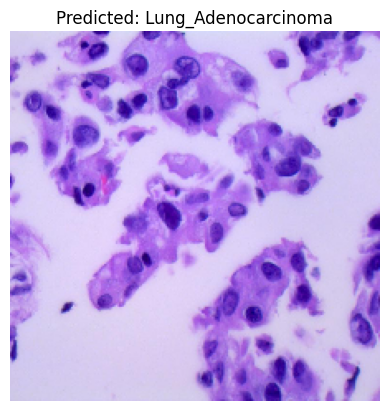

In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

def predict_image_class(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    predicted_class = np.argmax(preds[0])

    class_labels = list(train_generator.class_indices.keys()) # Assuming train_generator is defined as in your original code
    predicted_label = class_labels[predicted_class]

    print(f"Predicted class: {predicted_label}")

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}")
    plt.show()


# Example usage (replace with your image path and model)
image_path = "/content/Lung_Cancer_Split/test/Lung_Adenocarcinoma/lungaca1059.jpeg" #@param {type:"string"}
predict_image_class(image_path, loaded_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted class: Lung_Squamous_Cell_Carcinoma


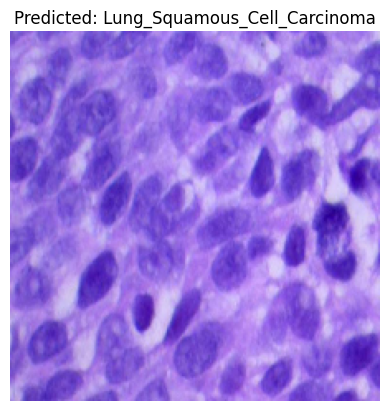

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

def predict_image_class(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    predicted_class = np.argmax(preds[0])

    class_labels = list(train_generator.class_indices.keys()) # Assuming train_generator is defined as in your original code
    predicted_label = class_labels[predicted_class]

    print(f"Predicted class: {predicted_label}")

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}")
    plt.show()


# Example usage (replace with your image path and model)
image_path = "/content/Lung_Cancer_Split/test/Lung_Squamous_Cell_Carcinoma/lungscc1190.jpeg" #@param {type:"string"}
predict_image_class(image_path, loaded_model)


In [23]:
import json

# Invert class indices to get idx -> label
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Save to JSON file
with open('/content/class_indices.json', 'w') as f:
    json.dump(index_to_class, f)


In [24]:
# Save preprocessing config as info
preprocess_info = {
    "image_size": [224, 224],
    "preprocessing": "resnet50"
}

with open('/content/preprocess_config.json', 'w') as f:
    json.dump(preprocess_info, f)


In [25]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
import json
from PIL import Image
import numpy as np

# Load model
model = load_model('/content/lung_cancer_model.h5')

# Load class indices
with open('/content/class_indices.json', 'r') as f:
    index_to_class = json.load(f)

def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.expand_dims(np.array(img), axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    class_label = index_to_class[str(class_idx)]
    confidence = prediction[0][class_idx]

    return class_label, confidence

# Example usage
# label, conf = predict_image('/content/test_image.jpg')
# print(f"Prediction: {label}, Confidence: {conf:.2f}")
